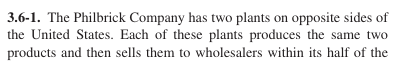
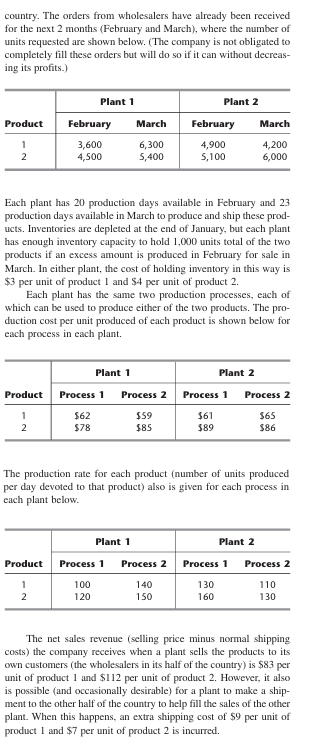
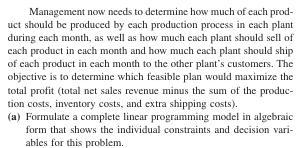

In [4]:
import gurobipy as gp
from gurobipy import Model,GRB
model = gp.Model("Philbrick Production Planning Model")

## Adding Variables ##
products = [1,2] ## Product Number
plants = [1,2] ## Plant Number
processes = [1,2] ## Process Number 
regions = [1,2] ## Shipping Region
months = [1,2] ## Month Number 

## Creating Dictionaries

d_ijm = {(1,1,1):3600,(1,1,2):6300,
        (2,1,1):4500,(2,1,2):5400,
        (1,2,1):4900,(1,2,2):4200,
        (2,2,1):5100,(2,2,2):6000}  ## Demand Dictionary (Demand of product i in plant j in month m)

## Production Costs ##
c_ijk = {(1,1,1):62,(1,1,2):59,
        (2,1,1):78,(2,1,2):85,
        (1,2,1):61,(1,2,2):65,
        (2,2,1):89,(2,2,2):86}  ## Cost of producing 1 unit of product i in plant j using process k

## Limit on Production ##
u_ijk = {(1,1,1):100,(1,1,2):140,
        (2,1,1):120,(2,1,2):150,
        (1,2,1):130,(1,2,2):110,
        (2,2,1):160,(2,2,2):130}   ## Production limit of producing product i in plant j using 

## Shipping Costs ##
s_ijl = {(1,1,1):0,(1,1,2):9,
        (2,1,1):0,(2,1,2):7,
        (1,2,1):9,(1,2,2):0,
        (2,2,1):7,(2,2,2):0}   ## Shipping cost of shipping product i made in plant j to region l

## Holding Cost ##
h_ij = {(1,1):3,(1,2):3,
       (2,1):4,(2,2):4}   ## Holding cost of 1 unit of product i at plant j

## Working Days ##
w_m = {1:20,2:23}       ## Number of working days in month m

## Inventory Capacity ##
inv_j = {1:1000,2:1000}  ## Total inventory capacity at plant j

price = {1:83,2:112}
## Defining Decision variables ##
P_ijkm = model.addVars(products,plants,processes,months,vtype = GRB.INTEGER,name = "Amount of product i produced in plant j using process k in month m",lb=0)
S_ijlm = model.addVars(products,plants,regions,months,vtype = GRB.INTEGER,name = "Amount of product i shipped from plant j to region l in month m",lb = 0)
I_ijm = model.addVars(products,plants,months,vtype = GRB.INTEGER,name = "Amount of excess inventory of product i in plant j in month m",lb = 0)

## Objective Function ##
## Revenue ##
revenue = gp.quicksum(price[i]*S_ijlm[i,j,l,m]
                     for i in products
                     for j in plants
                     for l in processes
                     for m in months)

## Cost of production per product produced ##
cost_of_production = gp.quicksum(c_ijk[i,j,k]*P_ijkm[i,j,k,m]
                                for i in products
                                for j in plants
                                for k in processes
                                for m in months)

## Shipping Cost of each product to each region ##
shipping_cost = gp.quicksum(s_ijl[i,j,l]*S_ijlm[i,j,l,m]
                           for i in products
                           for j in plants
                           for l in regions
                           for m in months)

## Cost of Holding Inventory ##
inventory_cost = gp.quicksum(h_ij[i,j]*I_ijm[i,j,m]
                            for i in products
                            for j in plants
                            for m in months)

## Objective Function ##
model.setObjective(revenue - cost_of_production - shipping_cost - inventory_cost,GRB.MAXIMIZE)


## Setting Model Constraints ##

## Production Limit Constraint ##
for i in products:
    for j in plants:
        for k in processes:
            for m in months:
                model.addConstr(P_ijkm[i,j,k,m] <= u_ijk[i,j,k]*w_m[m],
                               name=f"Cap_prod_p{i}_pl{j}_pr{k}_m{m}")

## Demand Constraint ##
for i in products:
    for j in plants:
        for m in months:
            model.addConstr(gp.quicksum(S_ijlm[i,j,l,m] for l in regions) <= d_ijm[i,j,m],
                           name=f"Demand_p{i}_pl{j}_m{m}")

## Inventory Constraint ##
for j in plants:
    model.addConstr(gp.quicksum(I_ijm[i,j,1] for i in products) <= inv_j[j],
                   name=f"InvCap_pl{j}")

## Shipping Constraint ##
for i in products:
    for j in plants:
        model.addConstr(gp.quicksum(S_ijlm[i,j,l,1] for l in regions) <= gp.quicksum(P_ijkm[i,j,k,1] for k in processes),
                       name=f"ShipProd_Feb_p{i}_pl{j}")

## Inevntory Balance of February ##
for i in products:
    for j in plants:
        for m in months:
            model.addConstr(I_ijm[i,j,1] == gp.quicksum(P_ijkm[i,j,k,1] for k in processes) - 
                           gp.quicksum(S_ijlm[i,j,l,1] for l in regions),
                           name=f"InvBal_Feb_p{i}_pl{j}")

## Inventory Remaing from feb into march to be used for sale in march ##
for i in products:
    for j in plants:
        model.addConstr(
            gp.quicksum(P_ijkm[i, j, k, 2] for k in processes)
            + I_ijm[i, j, 1]
            == gp.quicksum(S_ijlm[i, j, l, 2] for l in regions),
            name=f"Flow_Mar_p{i}_pl{j}"
        )

model.optimize()

if model.status == GRB.OPTIMAL:
    print(f"\nMaximized Profit : ${model.ObjVal:,.2f}\n")

    print("Production Plan:")
    for i in products:
        for j in plants:
            for k in processes:
                for m in months:
                    qty = P_ijkm[i,j,k,m].X
                    if qty > 0:
                        print(f"Product {i} - Plant {j} - Process {k} - Month {m} : {qty} units")

    print("\nShipping Plan:")
    for i in products:
        for j in plants:
            for l in regions:
                for m in months:
                    qty = S_ijlm[i,j,l,m].X
                    if qty > 0:
                        print(f"Product {i} - Plant {j} - Region {l} - Month {m} : {qty} units")

    print("\nInventory Plan:")
    for i in products:
        for j in plants:
            for m in months:
                qty = I_ijm[i,j,m].X
                print(f"Product {i} - Plant {j} - Month {m} : {qty} units in inventory")


else:
    print("Optimal Solution Not Found")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 42 rows, 40 columns and 112 nonzeros
Model fingerprint: 0xb60d589a
Variable types: 0 continuous, 40 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 6e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 41 rows and 36 columns
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Found heuristic solution: objective 858370.00000
Variable types: 0 continuous, 4 integer (0 binary)

Root relaxation: objective 9.834700e+05, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 